# 通过一个简单的例子，我们初步理解深度学习的例子
1. 根据历史数据预测未来的放假，我们将实现一个线性回归模型，并用梯度下降算法求解该模型，从而给出预测直线直线
2. 这个实例问题是：假如有历史房价数据，我们应如何预测未来某一天的房价？
3. 针对这个问题，我们的求解步骤包括：准备数据、设计模型、训练和预测

In [18]:
#导入需要使用的库
import numpy as np
import pandas as pd #读取csv文件的库
import matplotlib.pyplot as plt #导入画图的程序包
#我的环境是pytorch+cuda+cudnn
import torch
import torch.optim as optim

# 让输出的图形直接在Notebook中显示
%matplotlib inline

## 1. 准备工作 导入数据 
在这个简单例子里面 人为编造一批数据，从而重点关注方法和流程

假设我们每隔一个月能获得一次房价数据，那么时间数据可以为0,1，...， 表示几月份 我们可以用Pytorch的linspace来构造0-100之间的均匀数字作为时间变量x：


In [19]:
x = torch.linspace(0,100).type(torch.FloatTensor)

假如 这些时间点上的历史房价数据就是在x的基础上加上一定的噪声：

In [20]:
# torch.randn(100) 这个命令可以生成100个满足标准正态分布的随机数（均值为0，方差为1）
rand = torch.randn(100) *10
y = x + rand

现在我们有了100个时间点 $x_i$ 和每个时间点对应的房价 $y_i$ 。 其中，每一个 $x_i$ , $y_i$ 称为一个样本点

## 2. 划分数据集 将其切分为训练集和训练集两部分

在下面这段代码中,:-10是指从x变量中取出倒数第10个元素之前的所有元素; 而-10:是指取出x中倒数10个元素。
所以我们就把第0到90个月的数据当做训练集，把后10个月的数据当做测试集

In [21]:
x_train = x[:-10]
x_test = x[-10:]
y_train = y[:-10]
y_test = y[-10:]

接下来，对训练数据点进行可视化

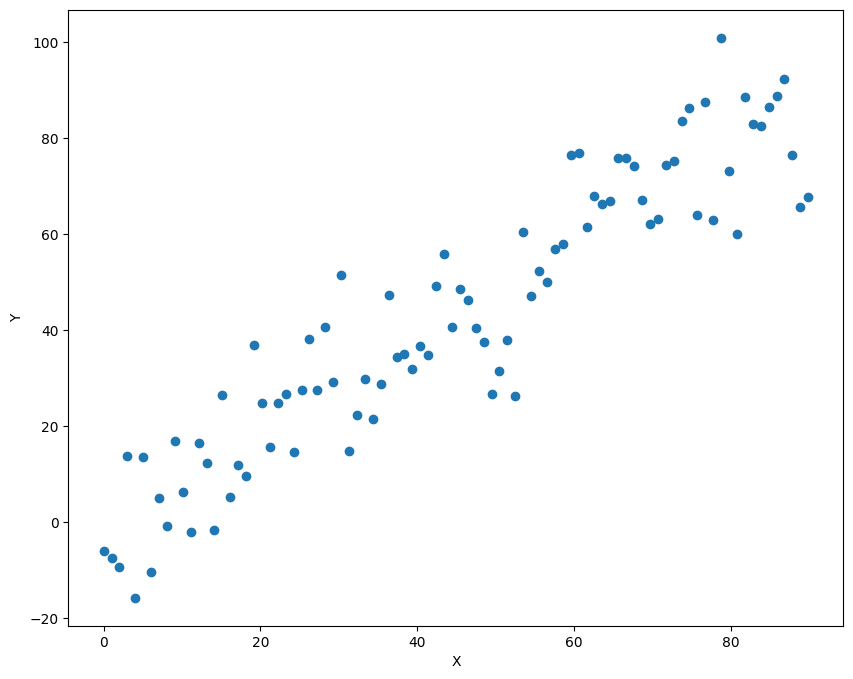

In [25]:
plt.figure(figsize=(10,8)) #设定绘制窗口大小
plt.plot(x_train,y_train,'o') 
#由于x和y都是自动微分变量，因此需要用data获取它们包裹的tensor，并转换为Numpy 但现在的版本好像并不需要这么做
#plt.plot(x_train.data.numpy(),y_train.data.numpy(),'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## 3. 设计模型

我们希望得到一条尽可能从中间穿越这些数据散点的拟合直线 $y = ax+b $. 接下来的问题是, 求解参数a、b的数值，代入之后计算出一个$y_i$ 

通过定义一个平均函数来让它尽可能小，通过梯度学习来反复迭代，这里不赘述

这里还需要引入一个学习率的概念，它可以调节更新的快慢，太大的时候得到的最优值不准，但太小的话学习时间就会很慢

PyTorch()的backward()可以非常方便的算出这些偏导数


### 3.1 训练

接下来，我们将上述思路转化为PyTorch代码，首先我们要定义两个自动微分变量a和b

In [27]:
a = torch.rand(1,requires_grad = True)
b = torch.rand(1,requires_grad = True)

可以看到，在初始的时候，a和b都是随机取值的，设置学习率：

In [30]:
learning_rate = 0.0001

然后，完成对a和b的迭代计算：

In [37]:
for i in range(1000):
    #计算在当前a、b条件下的模型预测值
    predictions = a.expand_as(x_train) * x_train + b.expand_as(x_train)
    # 将所有训练数据代入ax+b,计算每个的预测值，这里的x_train和predictions都是（90,1）的张量
    # Expand_as的作用是将a、b扩充维度和x_train一致
    loss = torch.mean((predictions - y_train) **2) #通过与标签数字y比较计算误差，loss是一个标量
    #print('loss',loss)
    loss.backward() #对损失函数进行梯度反转
    #利用上一步计算得到的a、b的梯度信息更新a、b中的data数值
    a.data.add_(- learning_rate * a.grad.data)
    b.data.add_(- learning_rate * b.grad.data)
    # 清空梯度 以防不停地增加
    a.grad.data.zero_()
    b.grad.data.zero_()

在PyTorch，如果某个函数后面加上了“_” ,就表明要用这个函数的计算结果更新当前的变量

最后，将原始的数据散点联合拟合的直线画出来

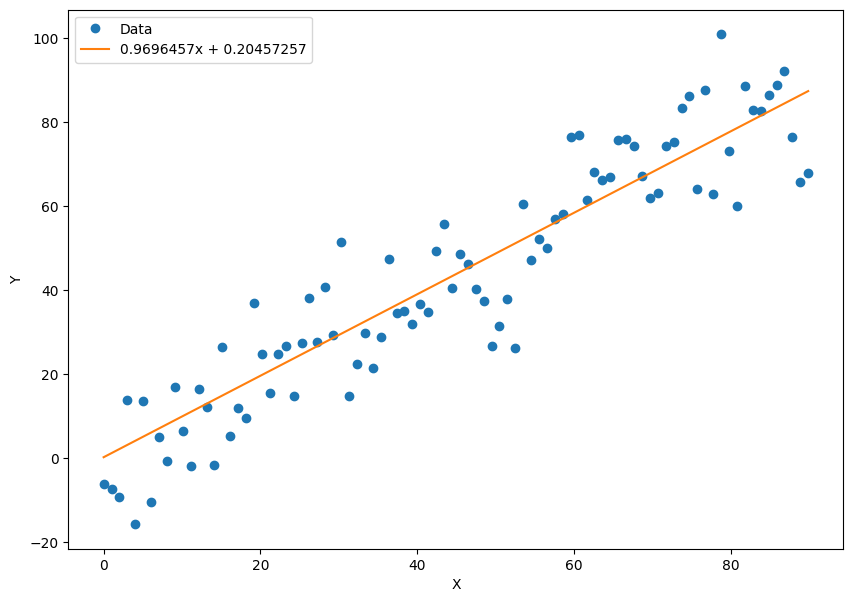

In [40]:
x_data = x_train.data.numpy() #将x中的数据转换为Numpy数组
plt.figure(figsize = (10,7)) 
xplot, = plt.plot(x_data,y_train.data.numpy(),'o')
yplot, = plt.plot(x_data,a.data.numpy() * x_data + b.data.numpy())
plt.xlabel('X')
plt.ylabel('Y')
str1 = str(a.data.numpy()[0]) + 'x + ' + str(b.data.numpy()[0]) #将拟合直线的参数a，b显示出来
plt.legend([xplot,yplot],['Data',str1])  #绘制图例
plt.show()

### 3.2 预测

在测试数据集上应用我们拟合的直线来预测对应的 $y$,也就是房价。只需要将测试数据的 $x$值代入我们拟合的直线


In [42]:
predictions = a.expand_as(x_test) * x_test + b.expand_as(x_test) #计算模型的预测结果
predictions #输出


tensor([88.3542, 89.3336, 90.3131, 91.2925, 92.2719, 93.2514, 94.2308, 95.2103,
        96.1897, 97.1691], grad_fn=<AddBackward0>)

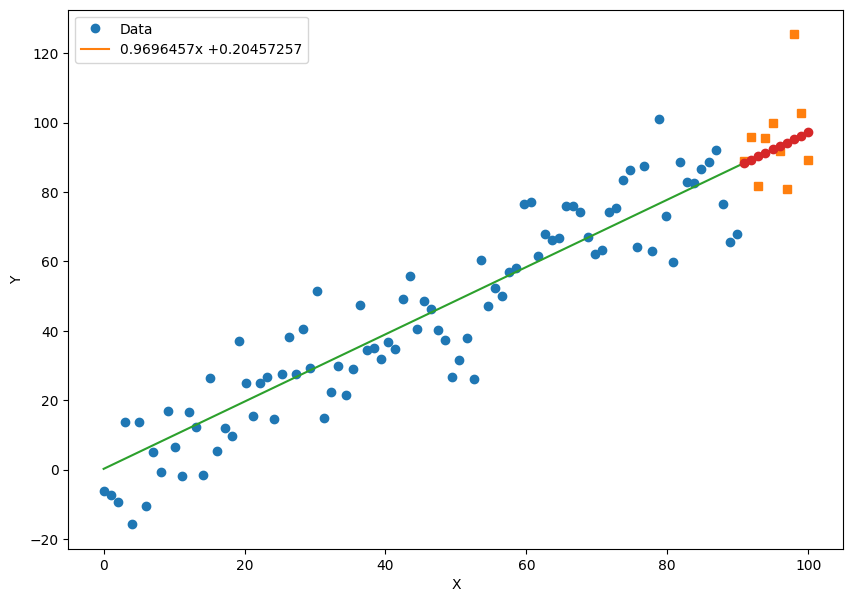

In [43]:
x_data = x_train.data.numpy() # 获得x包裹的数据
x_pred = x_test.data.numpy() # 获得包裹的测试数据的自变量
plt.figure(figsize = (10, 7)) # 设定绘图窗口大小
plt.plot(x_data, y_train.data.numpy(), 'o') # 绘制训练数据
plt.plot(x_pred, y_test.data.numpy(), 's') # 绘制测试数据
x_data = np.r_[x_data, x_test.data.numpy()]
plt.plot(x_data, a.data.numpy() * x_data + b.data.numpy())  # 绘制拟合数据
plt.plot(x_pred, a.data.numpy() * x_pred + b.data.numpy(), 'o') # 绘制预测数据
plt.xlabel('X') # 更改横坐标轴标注
plt.ylabel('Y') # 更改纵坐标轴标注
str1 = str(a.data.numpy()[0]) + 'x +' + str(b.data.numpy()[0]) # 图例信息
plt.legend([xplot, yplot],['Data', str1]) # 绘制图例
plt.show()